In [49]:
import re
from io import StringIO
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import neurokit2 as nk

In [50]:
def parse_file(file_path):
    with open(file_path) as file:
        content = file.read()
    
    client_name = re.search(r'Client:\s*(.+?)\s*Channel Set:', content).group(1).strip()
    csv_part = content.split('\n\n')[2].strip()

    raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]
    eda, info = nk.eda_process(raw, sampling_rate=256, report=client_name)    
    return client_name, eda, info

In [52]:
def eda_plot_dashedsegments(
    eda_signals, ax, x_axis, onsets, peaks, half_recovery
):
    # Mark onsets, peaks, and half-recovery.
    onset_x_values = x_axis[onsets]
    onset_y_values = eda_signals["EDA_Phasic"][onsets].values
    peak_x_values = x_axis[peaks]
    peak_y_values = eda_signals["EDA_Phasic"][peaks].values
    halfr_x_values = x_axis[half_recovery]
    halfr_y_values = eda_signals["EDA_Phasic"][half_recovery].values

    end_onset = pd.Series(
        eda_signals["EDA_Phasic"][onsets].values, eda_signals["EDA_Phasic"][peaks].index
    )

    risetime_coord = []
    amplitude_coord = []
    halfr_coord = []

    for i in range(len(onsets)):
        # Rise time.
        start = (onset_x_values[i], onset_y_values[i])
        end = (peak_x_values[i], onset_y_values[i])
        risetime_coord.append((start, end))

    for i in range(len(peaks)):
        # SCR Amplitude.
        start = (peak_x_values[i], onset_y_values[i])
        end = (peak_x_values[i], peak_y_values[i])
        amplitude_coord.append((start, end))

    for i in range(len(half_recovery)):
        # Half recovery.
        end = (halfr_x_values[i], halfr_y_values[i])
        peak_x_idx = np.where(peak_x_values < halfr_x_values[i])[0][-1]
        start = (peak_x_values[peak_x_idx], halfr_y_values[i])
        halfr_coord.append((start, end))


    # Plot with matplotlib.
    # Mark onsets, peaks, and half-recovery.
    ax.scatter(
        x_axis[onsets],
        eda_signals["EDA_Phasic"][onsets],
        color="#FFA726",
        label="SCR - Onsets",
        zorder=2,
    )
    ax.scatter(
        x_axis[peaks],
        eda_signals["EDA_Phasic"][peaks],
        color="#1976D2",
        label="SCR - Peaks",
        zorder=2,
    )
    ax.scatter(
        x_axis[half_recovery],
        eda_signals["EDA_Phasic"][half_recovery],
        color="#FDD835",
        label="SCR - Half recovery",
        zorder=2,
    )

    ax.scatter(x_axis[end_onset.index], end_onset.values, alpha=0)

    return risetime_coord, amplitude_coord, halfr_coord

In [57]:
def plot_data(eda_signal, info, name):
    peaks = np.where(eda_signals["SCR_Peaks"] == 1)[0]
    onsets = np.where(eda_signals["SCR_Onsets"] == 1)[0]
    half_recovery = np.where(eda_signals["SCR_Recovery"] == 1)[0]
    
    # clean peaks that do not have onsets
    if len(peaks) > len(onsets):
        peaks = peaks[1:]
    
    # Determine unit of x-axis.
    x_label = "Time (seconds)"
    x_axis = np.linspace(0, len(eda_signals) / info["sampling_rate"], len(eda_signals))
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 8))
    
    last_ax = fig.get_axes()[-1]
    last_ax.set_xlabel(x_label)
    
    # Plot cleaned and raw electrodermal activity.
    ax0.set_title("Raw and Cleaned Signal")
    fig.suptitle(f"Electrodermal Activity (EDA) - {name}", fontweight="bold")
    
    ax0.plot(x_axis, eda_signals["EDA_Raw"], color="#B0BEC5", label="Raw", zorder=1)
    ax0.plot(
        x_axis,
        eda_signals["EDA_Clean"],
        color="#9C27B0",
        label="Cleaned",
        linewidth=1.5,
        zorder=1,
    )
    ax0.legend(loc="upper right")
    
    # Plot skin conductance response.
    ax1.set_title("Skin Conductance Response (SCR)")
    
    # Plot Phasic.
    ax1.plot(
        x_axis,
        eda_signals["EDA_Phasic"],
        color="#E91E63",
        label="Phasic Component",
        linewidth=1.5,
        zorder=1,
    )
    
    # Mark segments.
    risetime_coord, amplitude_coord, halfr_coord = eda_plot_dashedsegments(
        eda_signals, ax1, x_axis, onsets, peaks, half_recovery
    )
    
    risetime = matplotlib.collections.LineCollection(
        risetime_coord, colors="#FFA726", linewidths=1, linestyle="dashed"
    )
    ax1.add_collection(risetime)
    
    amplitude = matplotlib.collections.LineCollection(
        amplitude_coord, colors="#1976D2", linewidths=1, linestyle="solid"
    )
    ax1.add_collection(amplitude)
    
    halfr = matplotlib.collections.LineCollection(
        halfr_coord, colors="#FDD835", linewidths=1, linestyle="dashed"
    )
    ax1.add_collection(halfr)
    ax1.legend(loc="upper right")
    
    # Plot Tonic.
    ax2.set_title("Skin Conductance Level (SCL)")
    ax2.plot(
        x_axis,
        eda_signals["EDA_Tonic"],
        color="#673AB7",
        label="Tonic Component",
        linewidth=1.5,
    )
    ax2.legend(loc="upper right")
    fig.savefig(f"../assets/bio-plots/{name}.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


/tmp/ipykernel_6105/575108945.py:8: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667


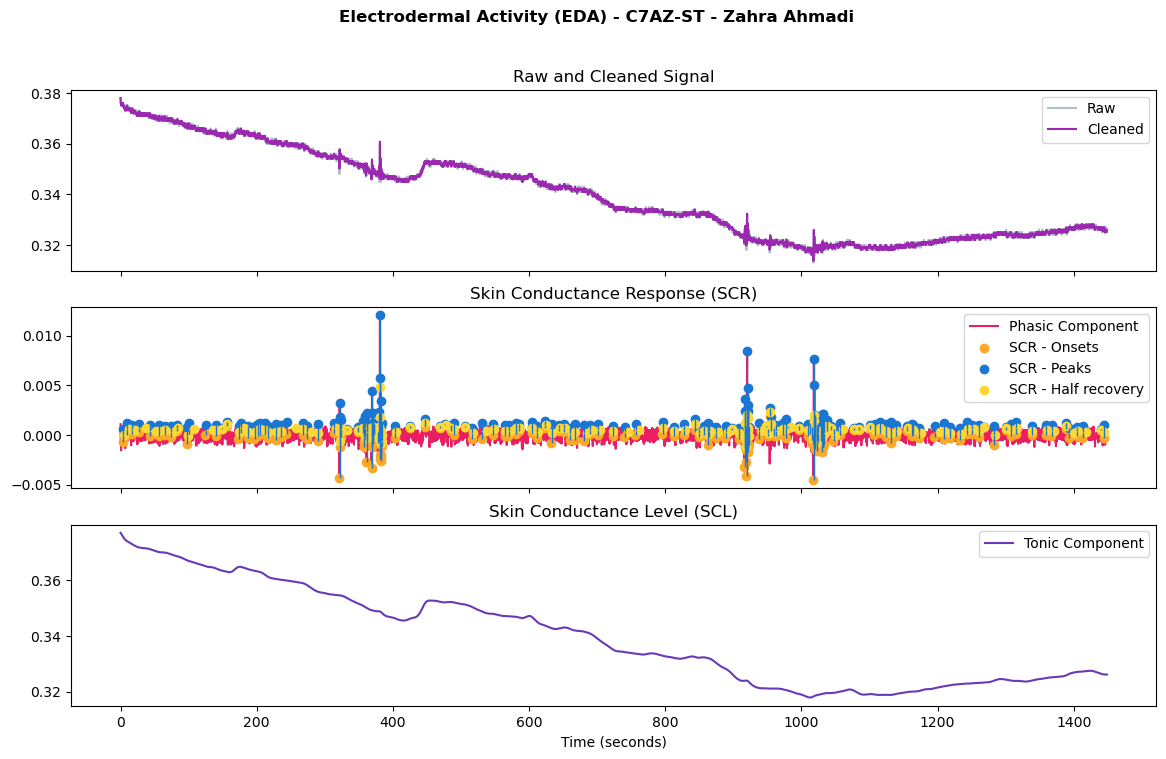

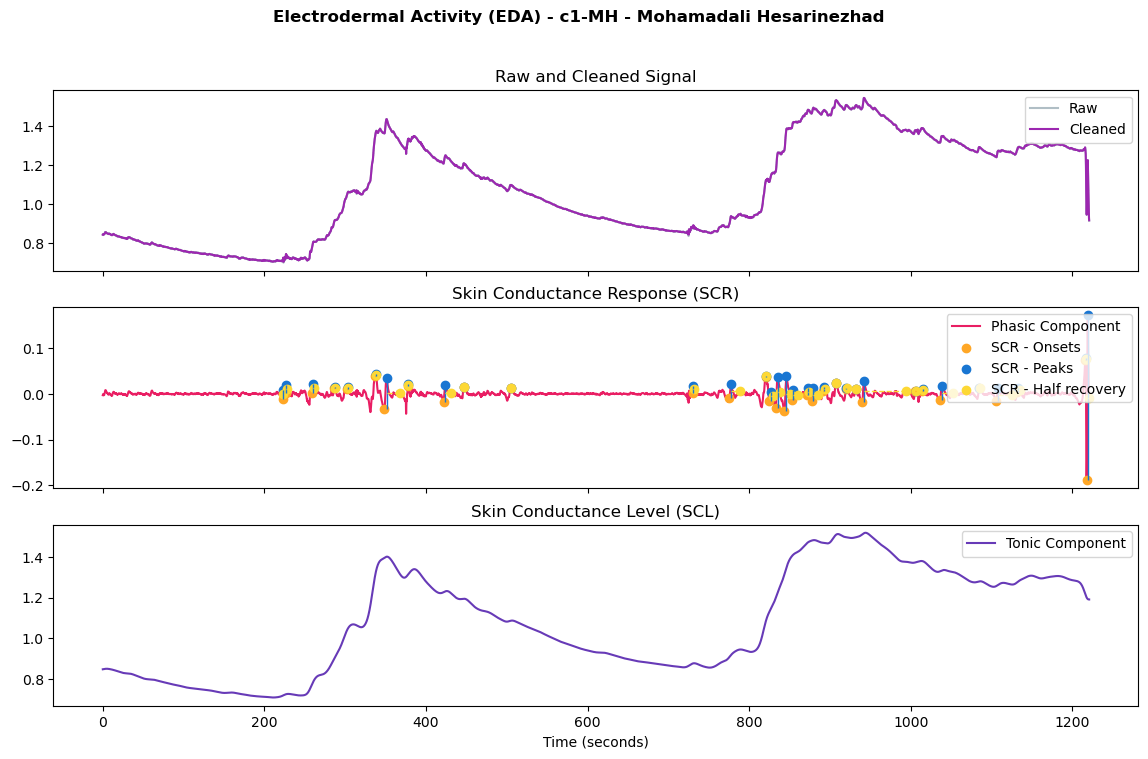

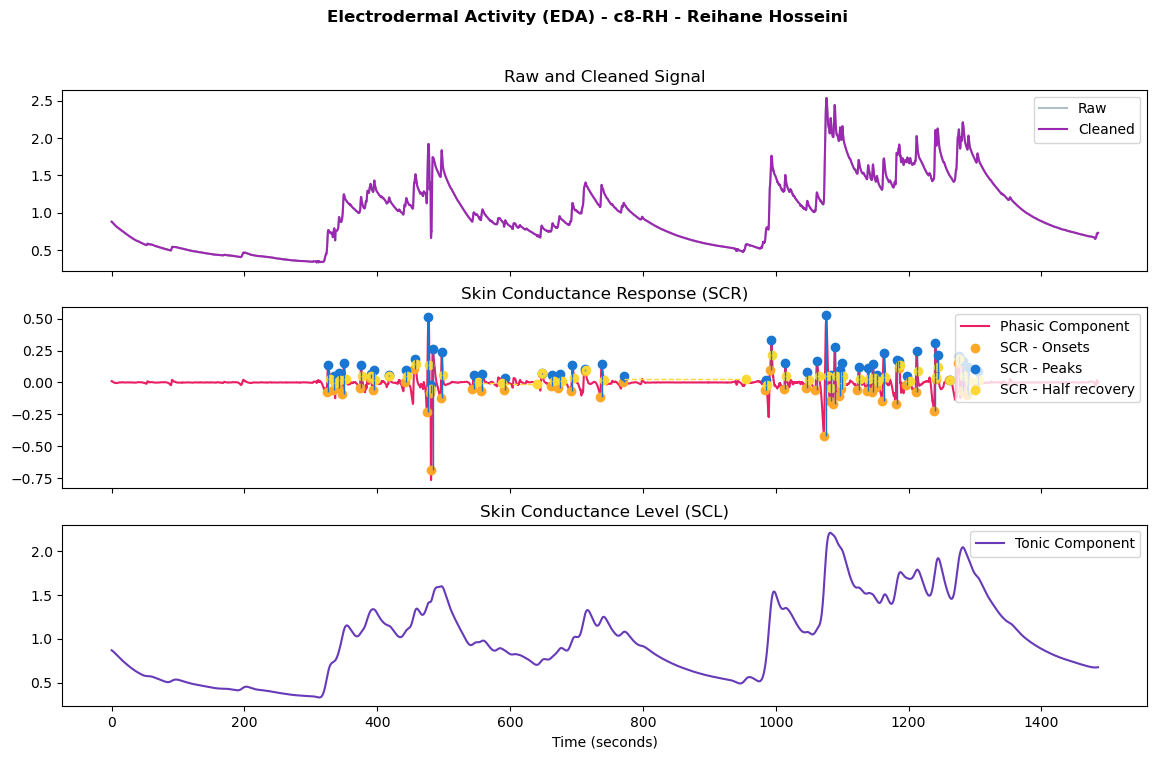

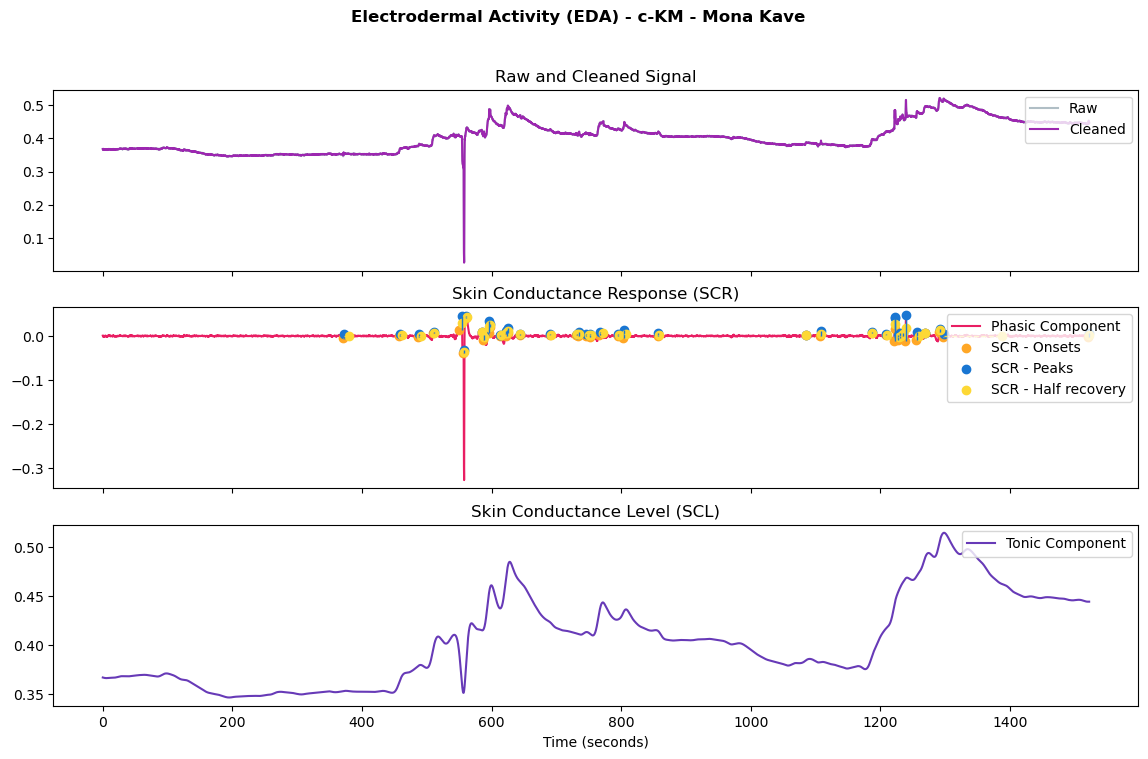

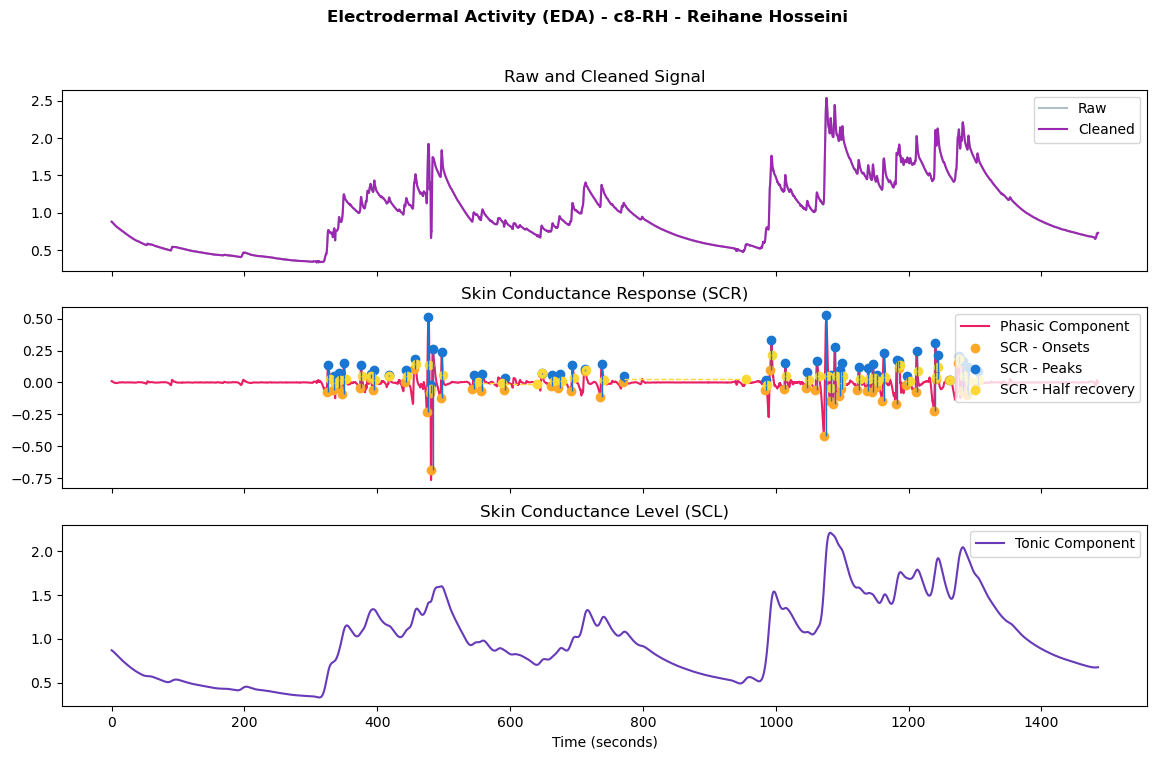

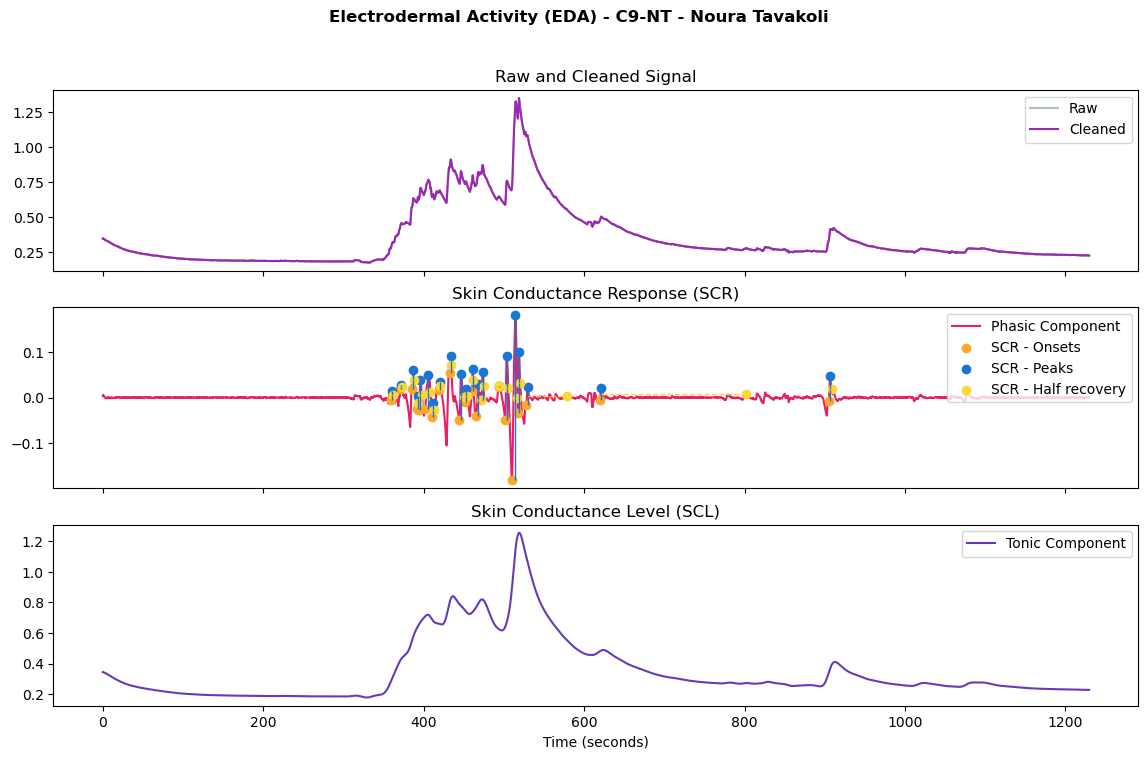

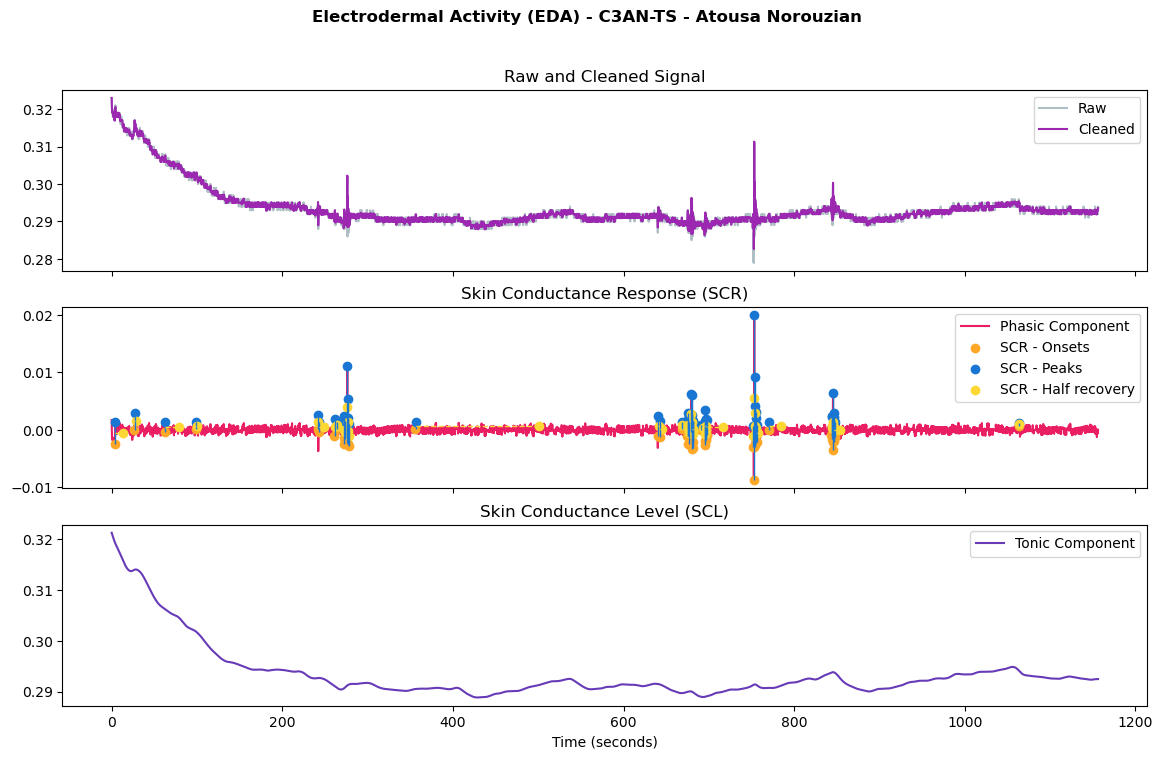

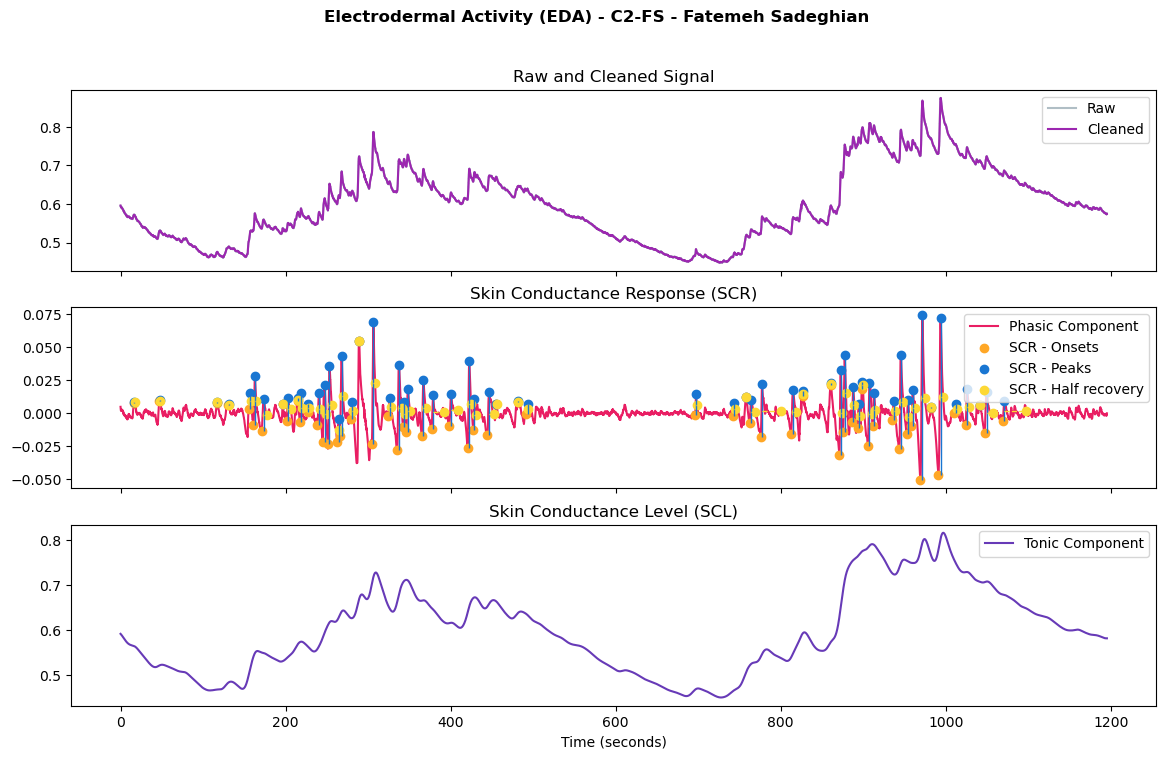

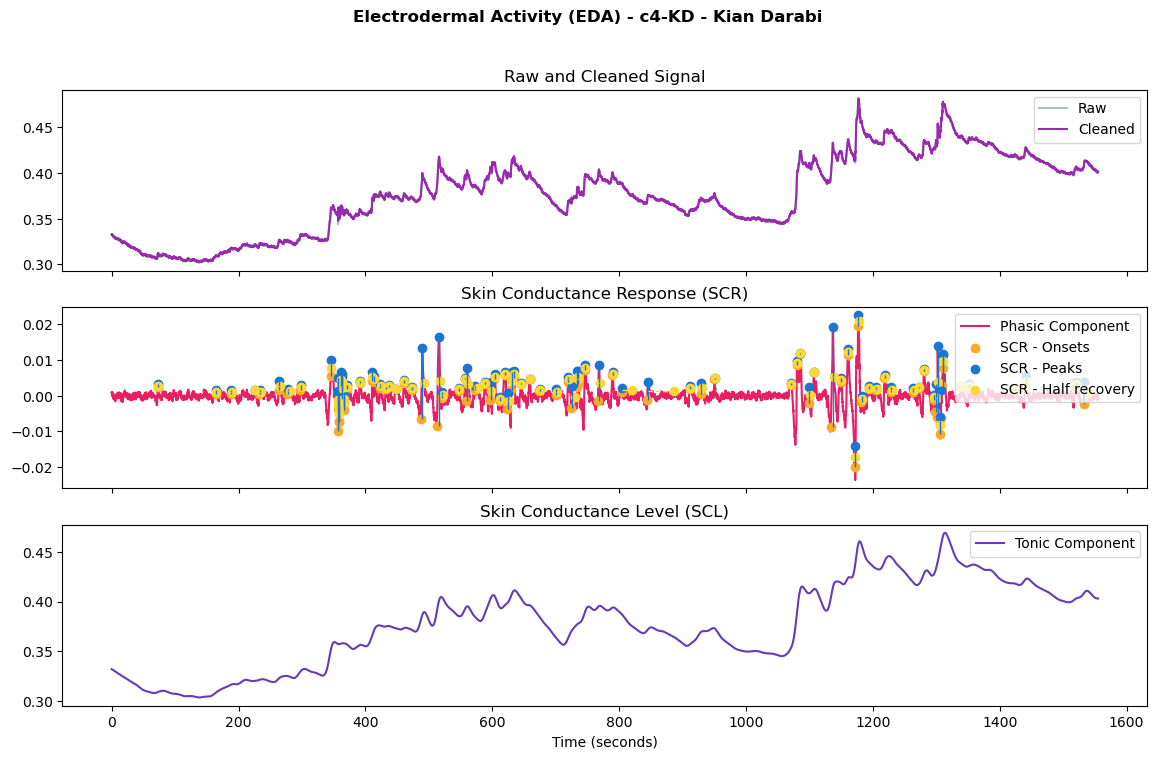

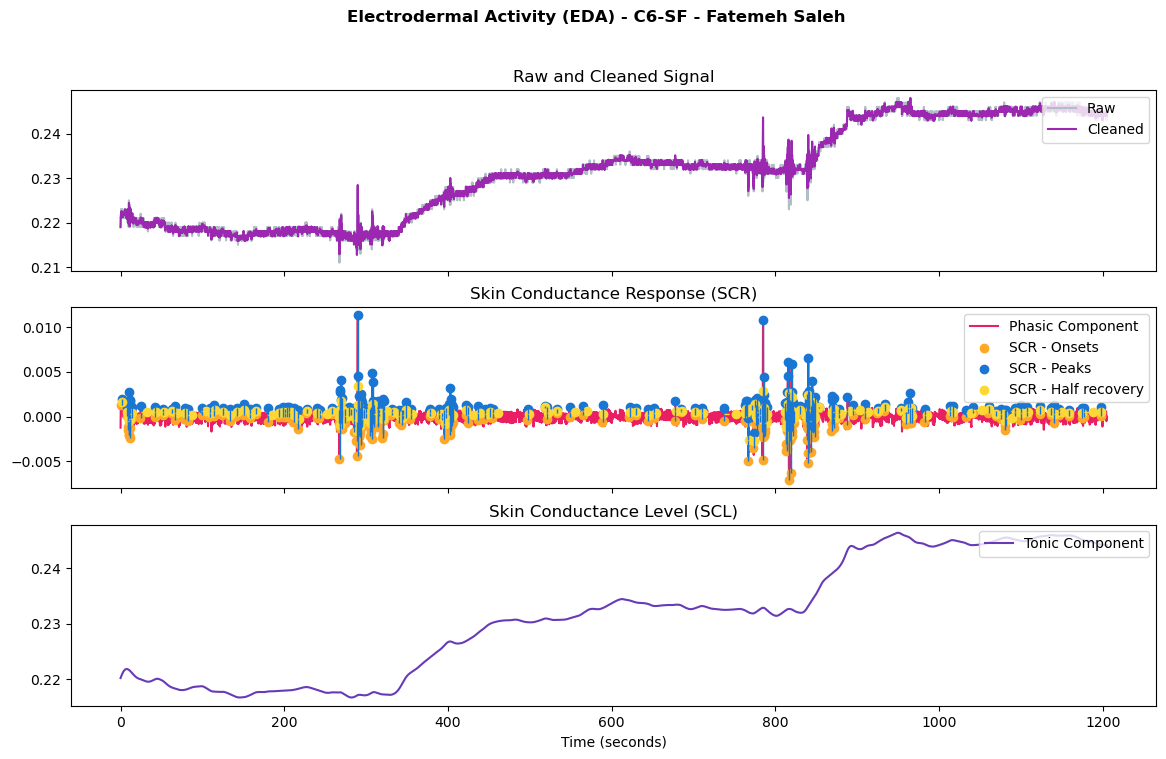

In [59]:
directory = "../assets/bio"

for file_name in Path(directory).iterdir():
    client_name, eda_signals, info = parse_file(file_name)
    plot_data(eda_signals, info, client_name)
